In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import warnings
from datasets import Dataset
from datetime import datetime
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import mean_squared_error

os.chdir("../../")
random.seed(42)

### Load data

In [2]:
# Load data
train = pd.read_csv('data/processed/train_esg_shortened.csv')
train = train[train.transcript_esg.apply(lambda t: isinstance(t, str))]
test = pd.read_csv('data/processed/test_esg_shortened.csv')
test = test[test.transcript_esg.apply(lambda t: isinstance(t, str))]

In [3]:
train.head()

,symbol,year,quarter,transcript_esg,esg_score,esg_risk_level
0,A,2022,1,thank emily welcome everyone agilents conferen...,15.0,Low
1,A,2022,3,thank hannah welcome everyone agilents confere...,15.0,Low
2,AAPL,2022,1,good day welcome apple q fy earnings conferenc...,17.0,Low
3,AAPL,2022,2,good day welcome apple q fy earnings conferenc...,17.0,Low
4,AAPL,2022,3,good day welcome apple q fy earnings conferenc...,17.0,Low


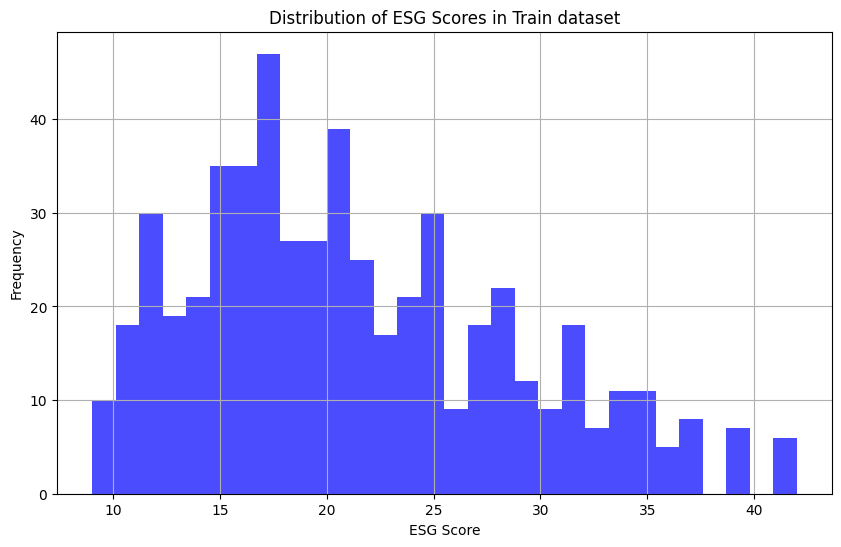

In [4]:
# Plotting the distribution of 'esg_score'
plt.figure(figsize=(10, 6))
plt.hist(train['esg_score'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of ESG Scores in Train dataset')
plt.xlabel('ESG Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Load model

In [5]:
BASE_MODEL = "google-bert/bert-base-uncased"
LEARNING_RATE = 1e-4
MAX_LENGTH = 512
BATCH_SIZE = 12
EPOCHS = 32

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Prepare datasets

In [6]:
def get_dataset(df):
    ds = tokenizer(list(df["transcript_esg"]), truncation=True, padding="max_length", max_length=MAX_LENGTH)
    ds["label"] = list(df["esg_score"])
    return ds

train = train.sample(frac=1, random_state=42)
dataset_train = get_dataset(train[:int(train.shape[0] * 0.8)])
dataset_val = get_dataset(train[int(train.shape[0] * 0.8):])

In [7]:
dataset_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'label'])

### Prepare for training

In [8]:
timestamp = datetime.now().strftime("%y%m%d_%H%M")
training_args = TrainingArguments(
    output_dir=f"checkpoints/bert_finetuned_{timestamp}/",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    # metric_for_best_model="mse",
    greater_is_better=False,
    save_total_limit=2,
    load_best_model_at_end=True,
    weight_decay=0.01,
    report_to="none",
)

### Training

In [9]:
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)
    
    mse = mean_squared_error(labels, logits)
    matches = [int(x // 20 == y // 20) for x, y in zip(logits, labels)]
    accuracy = sum(matches) / len(matches)

    return {
        # "mse": mse, 
        "accuracy": accuracy
    }

In [10]:
dataset_train = Dataset.from_dict(dataset_train)
dataset_val = Dataset.from_dict(dataset_val)

In [11]:
dataset_train

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 435
})

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    compute_metrics=compute_metrics_for_regression,
)

In [13]:
warnings.filterwarnings("ignore")
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,352.562600,269.018494,0.467890
2,183.027000,160.510101,0.467890
3,113.994600,120.100937,0.467890
4,86.241100,97.888191,0.467890
5,71.116700,83.217369,0.467890
6,62.797500,73.286819,0.467890
7,56.018100,67.339500,0.467890
8,53.295700,64.634590,0.495413
9,53.946700,64.109993,0.495413
10,54.072400,62.813141,0.495413


TrainOutput(global_step=608, training_loss=56.348155071860866, metrics={'train_runtime': 423.3395, 'train_samples_per_second': 32.881, 'train_steps_per_second': 1.436, 'total_flos': 3662473006448640.0, 'train_loss': 56.348155071860866, 'epoch': 32.0})

### Evaluation 

In [14]:
dataset_test = get_dataset(test)
dataset_test = Dataset.from_dict(dataset_test)
dataset_test

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 138
})

In [15]:
trainer.eval_dataset = dataset_test
warnings.filterwarnings("ignore")
trainer.evaluate()

{'eval_loss': 42.71034240722656,
 'eval_accuracy': 0.6811594202898551,
 'eval_runtime': 1.1486,
 'eval_samples_per_second': 120.146,
 'eval_steps_per_second': 5.224,
 'epoch': 32.0}

### Save model

In [18]:
# trainer.model.save_pretrained(f"models/bert_finetuned_{timestamp}")

### Save model inferencing results

In [32]:
def get_risk_level(score):
    if score < 10:
        return "Negligible"
    if score < 20:
        return "Low"
    if score < 30:
        return "Medium"
    if score < 40:
        return "High"
    return "Severe"

def get_results(df):
    
    nb_batches = len(df) // BATCH_SIZE + 1
    esg_score_pred = []

    for i in range(nb_batches):
        input_texts = list(df[i * BATCH_SIZE: (i+1) * BATCH_SIZE]["transcript_esg"])
        encoded = tokenizer(input_texts, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_tensors="pt").to("cuda")
        esg_score_pred += model(**encoded).logits.reshape(-1).tolist()
    
    df["esg_score_pred"] = esg_score_pred
    df["esg_risk_level_pred"] = df["esg_score_pred"].apply(get_risk_level)
    
    return df

In [34]:
get_results(train)

,symbol,year,quarter,transcript_esg,esg_score,esg_risk_level,esg_score_pred,esg_risk_level_pred
460,SWKS,2022,1,good afternoon welcome skyworks solution first...,28.0,Medium,24.928537,Medium
258,JPM,2022,3,firm reported net income billion eps revenue b...,29.0,Medium,24.928534,Medium
360,NEE,2022,2,good morning everyone welcome nextera energy n...,28.0,Medium,24.928543,Medium
535,WMT,2023,1,greeting welcome walmarts fiscal year first qu...,25.0,Medium,24.928537,Medium
545,ZTS,2022,1,thank operator good morning everyone welcome z...,18.0,Low,17.094320,Low
...,...,...,...,...,...,...,...,...
71,CAG,2023,2,good morning everyone welcome conagra brand se...,32.0,High,24.928539,Medium
106,CRM,2022,3,lady gentleman thank standing welcome salesfor...,13.0,Low,12.393847,Low
271,KO,2022,1,thanks tim good morning everyone first foremos...,23.0,Medium,24.928530,Medium
438,PYPL,2022,2,providing slide presentation accompany comment...,16.0,Low,15.392840,Low


In [37]:
sum(train.esg_risk_level == train.esg_risk_level_pred) / train.shape[0]

0.6985294117647058

In [38]:
get_results(test)

,symbol,year,quarter,transcript_esg,esg_score,esg_risk_level,esg_score_pred,esg_risk_level_pred
0,ADP,2022,1,call reference nongaap financial measures beli...,14.0,Low,15.461826,Low
1,ADP,2022,1,call reference nongaap financial measures beli...,14.0,Low,15.461826,Low
2,ADSK,2022,1,addition replay call available autodeskcominve...,16.0,Negligible,15.000785,Low
3,ADSK,2022,3,addition replay call available autodeskcominve...,16.0,Negligible,24.928467,Medium
4,ADSK,2022,4,addition replay call available autodeskcominve...,16.0,Negligible,14.814432,Low
...,...,...,...,...,...,...,...,...
133,VRTX,2022,2,reshma kewalramani vertexs ceo president stuar...,23.0,Medium,24.928530,Medium
134,VRTX,2022,3,reshma kewalramani vertexs ceo president stuar...,23.0,Medium,24.928534,Medium
135,XRAY,2022,1,begin let start im excited took role interim c...,16.0,Negligible,24.928528,Medium
136,XYL,2022,2,good morning everyone welcome xylems second qu...,16.0,Negligible,18.795809,Low


In [39]:
sum(test.esg_risk_level == test.esg_risk_level_pred) / test.shape[0]

0.4420289855072464

In [40]:
# train.to_csv(f"results/bert_finetuned/bert_finetuned_{timestamp}_train.csv")
# test.to_csv(f"results/bert_finetuned/bert_finetuned_{timestamp}_test.csv")